In [1]:
# importacao das bibliotecas utilizadas
import numpy as np
import cv2
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importacao das imagens
baboon = cv2.imread('imgs/baboon.pgm',cv2.IMREAD_GRAYSCALE)
fiducial = cv2.imread('imgs/fiducial.pgm',cv2.IMREAD_GRAYSCALE)
monarch = cv2.imread('imgs/monarch.pgm',cv2.IMREAD_GRAYSCALE)

### Funções extras

In [3]:
def rescale(image,gmax,gmin,fmax,fmin):
    output = np.zeros(image.shape,dtype='uint8')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i][j] = (((gmax - gmin) / (fmax - fmin)) * (image[i][j] - fmin)) + gmin
    return output

### 1.1 Pontilhado Ordenado (Half-toning)

In [4]:
m33 = np.array([[6,8,4],[1,0,3],[5,2,7]])
m44 = np.array([[0,12,3,15],[8,4,11,7],[2,14,1,13],[10,6,9,5]])

In [5]:
def half_toning(img,mask):
    gmax = mask.shape[0]*mask.shape[1]
    gmin = 0
    fmax = 255
    fmin = 0
    
    img_norm = rescale(img,gmax,gmin,fmax,fmin)
    
    new_x = img_norm.shape[0] * mask.shape[0]
    new_y = img_norm.shape[1] * mask.shape[1]
    
    n = mask.shape[0]
    m = mask.shape[1]
    
    output = np.zeros((new_x,new_y),dtype='uint8')
    
    for i in range(img_norm.shape[0]):
        for j in range(img_norm.shape[1]):
            mask_res = np.ndarray(mask.shape)
            mask_res = mask < img_norm[i,j]
            
            for x in range(n):
                for y in range(m):
                    output[i*n+x,j*m+y] = mask_res[x,y]
    
    return output

In [6]:
def plotting_image_and_half(image,half):
    f = plt.figure()
    
    f.add_subplot(1,2,1)
    plt.imshow(image,'gray')
    
    f.add_subplot(1,2,2)
    plt.imshow(half,'gray')
    
    plt.show()

In [7]:
baboon_m33 = half_toning(baboon,m33)
fiducial_m33 = half_toning(fiducial,m33)
monarch_m33 = half_toning(monarch,m33)

In [8]:
baboon_m44 = half_toning(baboon,m44)
fiducial_m44 = half_toning(fiducial,m44)
monarch_m44 = half_toning(monarch,m44)

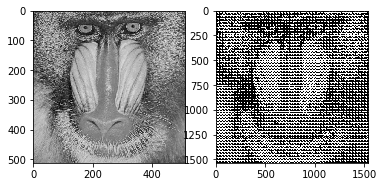

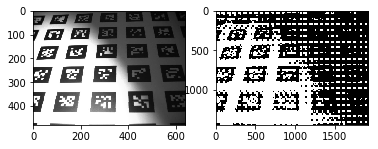

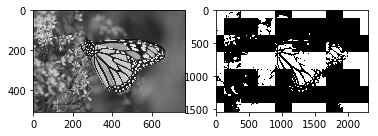

In [9]:
# resultado do half-toning com a máscara m33
plotting_image_and_half(baboon,baboon_m33)
plotting_image_and_half(fiducial,fiducial_m33)
plotting_image_and_half(monarch,monarch_m33)

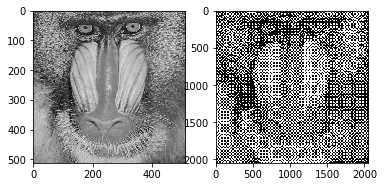

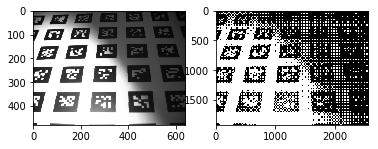

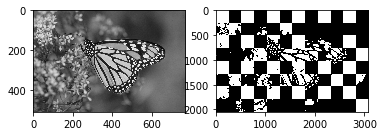

In [10]:
# resultado do half-toning com a máscara m44
plotting_image_and_half(baboon,baboon_m44)
plotting_image_and_half(fiducial,fiducial_m44)
plotting_image_and_half(monarch,monarch_m44)

In [11]:
# salvando os resultados
cv2.imwrite('resultados/baboon_m33.pbm',baboon_m33,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/baboon_m44.pbm',baboon_m44,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/fiducial_m33.pbm',fiducial_m33,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/fiducial_m44.pbm',fiducial_m44,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/monarch_m33.pbm',monarch_m33,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/monarch_m44.pbm',monarch_m44,(cv2.IMWRITE_PXM_BINARY, 0))

True

### 1.2 Pontilhado com Difusão de Erros (Floyd-Steinberg)

In [12]:
def floyd_steinberg_order1(img):
    T = 128
    n = img.shape[0]
    m = img.shape[1]
    
    output = img.copy()
    
    for i in range(n):
        for j in range(m):
            v_pixel = output[i,j]
            
            if v_pixel > T:
                error = v_pixel - 255
                output[i,j] = 255
            else:
                error = v_pixel - 0
                output[i,j] = 0
            
            e1 = np.round(error * (7.0 / 16.0))
            e2 = np.round(error * (3.0 / 16.0))
            e3 = np.round(error * (5.0 / 16.0))
            e4 = np.round(error * (1.0 / 16.0))
            
            if j+1 < m:
                output[i,j+1] = output[i,j+1] + e1
            if i+1 < n and j-1 >= 0:
                output[i+1,j-1] = output[i+1,j-1] + e2
            if i+1 < n:
                output[i+1,j] = output[i+1,j] + e3
            if i+1 < n and j+1 < m:
                output[i+1,j+1] = output[i+1,j+1] + e4
    
    return output

In [13]:
def floyd_steinberg_order2(img):
    T = 128
    n = img.shape[0]
    m = img.shape[1]
    
    output = img.copy()
    
    flag = True
    
    for i in range(n):
        if flag:
            for j in range(m):
                v_pixel = output[i,j]

                if v_pixel > T:
                    error = v_pixel - 255
                    output[i,j] = 255
                else:
                    error = v_pixel - 0
                    output[i,j] = 0

                e1 = np.round(error * (7.0 / 16.0))
                e2 = np.round(error * (3.0 / 16.0))
                e3 = np.round(error * (5.0 / 16.0))
                e4 = np.round(error * (1.0 / 16.0))

                if j+1 < m:
                    output[i,j+1] = output[i,j+1] + e1
                if i+1 < n and j-1 >= 0:
                    output[i+1,j-1] = output[i+1,j-1] + e2
                if i+1 < n:
                    output[i+1,j] = output[i+1,j] + e3
                if i+1 < n and j+1 < m:
                    output[i+1,j+1] = output[i+1,j+1] + e4
            flag = False
        else:
            for j in range(m-1,-1,-1):
                v_pixel = output[i,j]

                if v_pixel > T:
                    error = v_pixel - 255
                    output[i,j] = 255
                else:
                    error = v_pixel - 0
                    output[i,j] = 0

                e1 = np.round(error * (7.0 / 16.0))
                e2 = np.round(error * (3.0 / 16.0))
                e3 = np.round(error * (5.0 / 16.0))
                e4 = np.round(error * (1.0 / 16.0))

                if j-1 >= 0:
                    output[i,j-1] = output[i,j-1] + e1
                if i+1 < n and j+1 < m:
                    output[i+1,j+1] = output[i+1,j+1] + e2
                if i+1 < n:
                    output[i+1,j] = output[i+1,j] + e3
                if i+1 < n and j-1 >= 0:
                    output[i+1,j-1] = output[i+1,j-1] + e4
            flag = True
    return output

In [14]:
def plotting_image_and_floyd(image,floyd):
    f = plt.figure()
    
    f.add_subplot(1,2,1)
    plt.imshow(image,'gray')
    
    f.add_subplot(1,2,2)
    plt.imshow(floyd,'gray')
    
    plt.show()

In [15]:
baboon_floyd_order1 = floyd_steinberg_order1(baboon)
fiducial_floyd_order1 = floyd_steinberg_order1(fiducial)
monarch_floyd_order1 = floyd_steinberg_order1(monarch)

In [16]:
baboon_floyd_order2 = floyd_steinberg_order2(baboon)
fiducial_floyd_order2 = floyd_steinberg_order2(fiducial)
monarch_floyd_order2 = floyd_steinberg_order2(monarch)

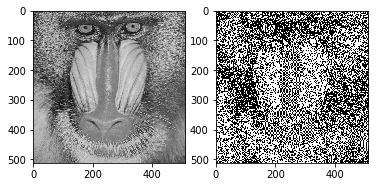

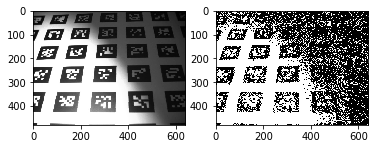

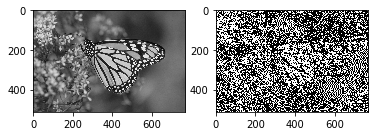

In [17]:
# resultado do floyd-steinberg com a ordem 1
plotting_image_and_floyd(baboon,baboon_floyd_order1)
plotting_image_and_floyd(fiducial,fiducial_floyd_order1)
plotting_image_and_floyd(monarch,monarch_floyd_order1)

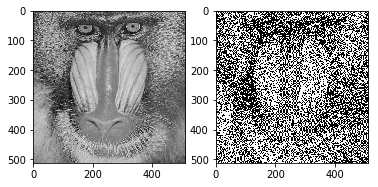

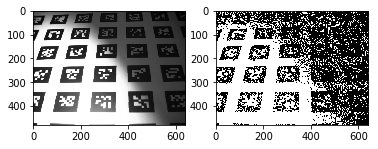

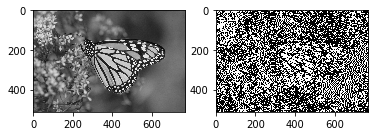

In [18]:
# resultado do floyd-steinberg com a ordem 2
plotting_image_and_floyd(baboon,baboon_floyd_order2)
plotting_image_and_floyd(fiducial,fiducial_floyd_order2)
plotting_image_and_floyd(monarch,monarch_floyd_order2)

In [19]:
# salvando os resultados
cv2.imwrite('resultados/baboon_floyd_order1.pbm',baboon_floyd_order1,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/baboon_floyd_order2.pbm',baboon_floyd_order2,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/fiducial_floyd_order1.pbm',fiducial_floyd_order1,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/fiducial_floyd_order2.pbm',fiducial_floyd_order2,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/monarch_floyd_order1.pbm',monarch_floyd_order1,(cv2.IMWRITE_PXM_BINARY, 0))
cv2.imwrite('resultados/monarch_floyd_order2.pbm',monarch_floyd_order2,(cv2.IMWRITE_PXM_BINARY, 0))

True